In [10]:
import os
from astropy.io import fits
from astropy.table import Table
import astropy.wcs as wcs
import astropy.units as u
from astropy.convolution import Gaussian2DKernel, convolve, convolve_fft, interpolate_replace_nans
from astropy.stats import mad_std, sigma_clipped_stats
import numpy as np
from radio_beam import Beam
from scipy.ndimage.morphology import binary_dilation, binary_closing
from reproject import reproject_interp
from matplotlib import pyplot as plt
from astropy.stats import SigmaClip
from photutils.segmentation import detect_threshold, detect_sources
from photutils.utils import circular_footprint
from photutils.background import Background2D
from matplotlib import colors 
import glob
from astropy.wcs import WCS
import regions
from mpl_toolkits.axes_grid1 import make_axes_locatable

from reduction_phangs_hst import contsub, contsub_misc, contsub_postprocess, contsub_postprocess_cosmicrays, contsub_postprocess_cosmicraysnnet

/var/folders/3y/cmsgt3_x7x72bbs__zhy_q6h0008wr/T/ipykernel_84508/3435606108.py:10: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_dilation, binary_closing
/var/folders/3y/cmsgt3_x7x72bbs__zhy_q6h0008wr/T/ipykernel_84508/3435606108.py:10: DeprecationWarning: Please use `binary_closing` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_dilation, binary_closing


In [2]:
def process_halpha_background(hdu_hst, halpha_filename, sigma_clip_sigma=3.0, detect_threshold_nsigma=2.0, 
                        detect_sources_npixels=10, footprint_radius=10, box_size=(100, 100), filter_size=(51, 51), 
                        exclude_percentile=95, fill_value=0.0):

    # Extracting the data from the hdu object
    data = hdu_hst.data

    # Defining the sigma clipping parameters
    sigma_clip = SigmaClip(sigma=sigma_clip_sigma, maxiters=10)

    # Calculating the detection threshold for the data
    threshold = detect_threshold(data, nsigma=detect_threshold_nsigma, sigma_clip=sigma_clip)

    # Detecting sources in the data above the threshold
    segment_img = detect_sources(data, threshold, npixels=detect_sources_npixels)

    # Creating a circular footprint for source detection
    footprint = circular_footprint(radius=footprint_radius)

    # Making a source mask using the footprint
    mask = segment_img.make_source_mask(footprint=footprint)

    # Creating a coverage mask to handle NaN values
    coverage_mask = ~np.isnan(data)

    # Creating a background estimator
    bkg = Background2D(data, box_size=box_size, filter_size=filter_size, mask=mask, 
                       exclude_percentile=exclude_percentile, fill_value=fill_value)

    # Getting the estimated background and subtracting it from the data
    data_bg = bkg.background
    data_bgsub = data - data_bg

    # Create a mask where True values represent NaN values in the original data
    mask = np.isnan(data)

    # Apply the mask to the background data, replacing detected positions (True) with NaNs
    data_bg[mask] = np.nan
    
    # Creating copies of the hdu object
    hdu_hst_bg = hdu_hst.copy()
    hdu_hst_bgsub = hdu_hst.copy()

    # Replacing the data in the copied hdu objects with the background and the background subtracted data
    hdu_hst_bg.data = np.array(data_bg, dtype=np.float32)
    hdu_hst_bgsub.data = np.array(data_bgsub, dtype=np.float32)

    # Defining the output filenames and writing the output to the files
    output_filename = halpha_filename.replace('_raw.fits', '_bg.fits')
    hdu_hst_bg.writeto(output_filename, overwrite=True)

    output_filename = halpha_filename.replace('_raw.fits', '_bgsub.fits')
    hdu_hst_bgsub.writeto(output_filename, overwrite=True)
    
    return(hdu_hst_bgsub)

In [3]:
rootdir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data/ngc628c/hst_contsub/f658n_f555w_f814w/'

In [11]:
hdu_hst = fits.open(rootdir+'ngc628c_halpha.fits')[0]

sigma_clip_sigma=3.0
detect_threshold_nsigma=2.0
detect_sources_npixels=10
footprint_radius=10
box_size=(100, 100)
filter_size=(51, 51)
exclude_percentile=95
fill_value=0.0

# Extracting the data from the hdu object
data = hdu_hst.data

# Defining the sigma clipping parameters
sigma_clip = SigmaClip(sigma=sigma_clip_sigma, maxiters=10)

# Calculating the detection threshold for the data
threshold = detect_threshold(data, nsigma=detect_threshold_nsigma, sigma_clip=sigma_clip)

sigma_clipped_stats(data)

(0.38773447, -0.45602688, 23.16785)

In [36]:
rms = mad_std(data, ignore_nan=True)
rms = mad_std(data[data<rms], ignore_nan=True)
mask_high = data > rms*5
mask_low = data > rms
mask = binary_dilation(mask_high, mask=mask_low, iterations=-1)

In [51]:
mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

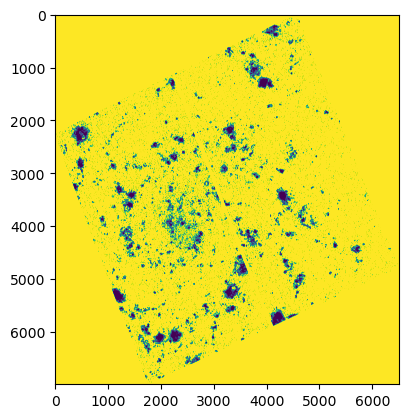

In [38]:
plt.imshow(~mask)

(<matplotlib.image.AxesImage at 0x7fb59f333a00>, -3.1425111330789464)

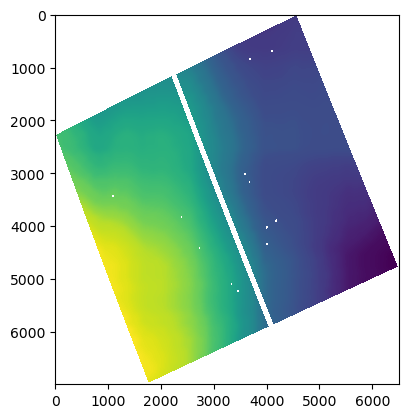

In [49]:
bkg = Background2D(data, 
                   box_size=(100, 100), 
                   filter_size=(51, 51), 
                   mask=mask)

data_bg = bkg.background
data_bgsub = data - data_bg
coverage_mask = np.isnan(data)
data_bg[coverage_mask] = np.nan

plt.imshow(data_bg), np.nanmean(data_bg)

(<matplotlib.image.AxesImage at 0x7fb5789ea4c0>, 0.015173137948755976)

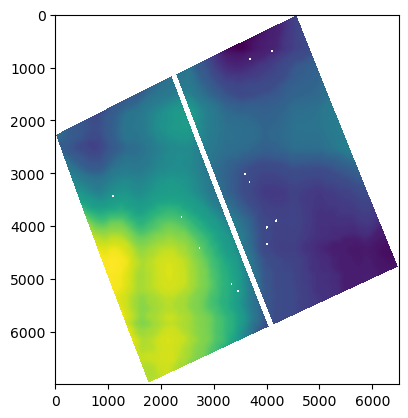

In [50]:
bkg = Background2D(data_bgsub, 
                   box_size=(100, 100), 
                   filter_size=(51, 51), 
                   mask=mask)

data_bg = bkg.background
coverage_mask = np.isnan(data)
data_bg[coverage_mask] = np.nan

plt.imshow(data_bg), np.nanmean(data_bg)

(<matplotlib.image.AxesImage at 0x7fb59f2c6cd0>, -3.0049665020701104)

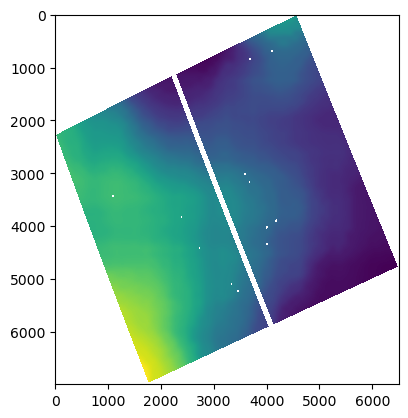

In [48]:
bkg = Background2D(data, 
                   box_size=(100, 100), 
                   filter_size=(25, 25), 
                   mask=mask)

data_bg = bkg.background
coverage_mask = np.isnan(data)
data_bg[coverage_mask] = np.nan

plt.imshow(data_bg), np.nanmean(data_bg)

[INFO] MUSE mask lims: 25.0 24363.0
[INFO] HST mask lims: -268.8 16159.5
[INFO] xy-fit --- slope: 0.5874077770602377, intercept: -144.51821076682992
[INFO] xy-fit scaled --- slope: 0.5874077770602377, intercept: -5.671416301230864


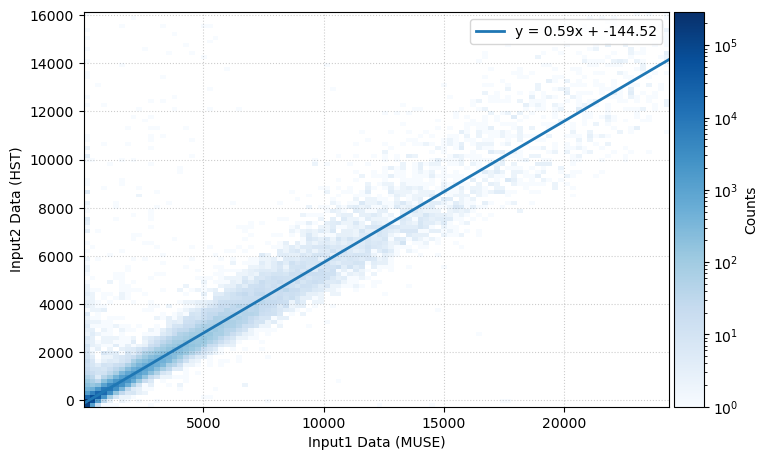

In [6]:
hdu_input1 = fits.open(rootdir+'ngc628c_musehalpha.fits')[0]
hdu_input2 = fits.open(rootdir+'ngc628c_halpha_smoothed_regrid.fits')[0]
hdu_input3 = fits.open(rootdir+'ngc628c_halpha.fits')[0]

output_filename = rootdir+'ngc628c_halpha_fit_anchored_musegrid.fits'

rootdir = os.path.dirname(output_filename)

valid_indices = np.isfinite(hdu_input1.data) & np.isfinite(hdu_input2.data)
x_data = hdu_input1.data[valid_indices]
y_data = hdu_input2.data[valid_indices]

xpmin = 0.1
ypmin = 0.1
xpmax = 99.9
ypmax = 99.9

x_minmask, x_maxmask = np.nanpercentile(x_data,xpmin), np.nanpercentile(x_data,xpmax)
y_minmask, y_maxmask = np.nanpercentile(y_data,ypmin), np.nanpercentile(y_data,ypmax)

print(f"[INFO] MUSE mask lims: %0.1f %0.1f" %(x_minmask, x_maxmask))
print(f"[INFO] HST mask lims: %0.1f %0.1f" %(y_minmask, y_maxmask))
x_mask = ((x_data>x_minmask) & (x_data<x_maxmask))
y_mask = ((y_data>y_minmask) & (y_data<y_maxmask))

x_data = x_data[x_mask&y_mask]
y_data = y_data[x_mask&y_mask]

# Calculate a line of best fit for the data
slope, intercept = np.polyfit(x_data, y_data, 1)
x_fit = np.linspace(np.min(x_data), np.max(x_data), 100)
y_fit = slope * x_fit + intercept
print(f"[INFO] xy-fit --- slope: {slope}, intercept: {intercept}")

# Create a 2D histogram plot using the filtered data
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal')

hist = ax.hist2d(x_data, y_data, bins=100, cmap='Blues', norm=colors.LogNorm())
ax.plot(x_fit, y_fit, color='C0', linewidth=2, label=f'y = {slope:.2f}x + {intercept:.2f}')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(hist[3], cax=cax, label='Counts')

ax.set_xlabel('Input1 Data (MUSE)')
ax.set_ylabel('Input2 Data (HST)')
ax.legend()
ax.grid(True, ls=':', color='k', alpha=0.2)

fig.savefig(rootdir+'fit.png', bbox_inches='tight')

# Apply the calculated line of best fit to the second input data and save it as a new FITS file

# Extract the WCS information from the input and template headers
wcs_input1 = wcs.WCS(hdu_input1.header)
wcs_input3 = wcs.WCS(hdu_input3.header)
pixscale_input1 = wcs.utils.proj_plane_pixel_area(wcs_input1.celestial)
pixscale_input3 = wcs.utils.proj_plane_pixel_area(wcs_input3.celestial)

pixscale_ratio = (pixscale_input3 / pixscale_input1)
print(f"[INFO] xy-fit scaled --- slope: {slope}, intercept: {intercept*pixscale_ratio}")

hdu_fit_anchored = hdu_input3.copy()
hdu_fit_anchored.data = (hdu_fit_anchored.data - (intercept*pixscale_ratio)) / slope
hdu_fit_anchored.writeto(output_filename, overwrite=True)